<a href="https://colab.research.google.com/github/niels-overby/SRP2021/blob/main/SRP_Widgets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [137]:
#@title Setup
#@markdown Tryk på pilen for at hente de nødvendige hjælpefilter og starte Colab serveren
!git clone https://github.com/niels-overby/SRP2021.git

%pip install soundfile

import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
import soundfile
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import os

import sys
sys.path.append('/content/SRP2021/')

from audiotools import utils, processing, spectrum


# helper functions 
def interferringTone(x,fs,freq=2000,level_dB = 65):
    A = utils.from_dB(level_dB)
    xlen = np.max(x.shape)
    
    x_sin = A * np.sin(2*np.pi*freq * np.arange(xlen)/fs)
    
    return x_sin

def interferringNoise(x,fs,SNR = 10):
    x_noise = np.random.randn(*x.shape)
    x_noise, _ = utils.adjustSNR(x,x_noise,SNR)
    
    return x_noise

fatal: destination path 'SRP2021' already exists and is not an empty directory.


# Widgets

I denne notebook kommer der til at være widgets hvor i kan bruge frekvensfiltrering og thresholding på jeres egne signaler.

## Upload af lydfiler.

Vær opmærksom på at kun .wav filer kan benyttes. Er dine egne filer i stereo benyttes kun venstre kanal i efterfølgende widgets.

Har du lydfiler i andre formater kan konverteres i f.eks. programmet Audacity eller lignende.

1. Klik på mappe ikonet venstre side
2. Klik på SRP2021
3. Klik på Audio
4. Drag and drop .wav filer ind i Audio-mappen.

Dine egne lydfiler bliver kun midlertidigt gemt I Google Colab, det betyder at de skal genuploades når du starter en ny session.

In [44]:
#@title Vælg fil

audioDir = '/content/SRP2021/Audio/'
audioFiles = list(np.sort([f for f in os.listdir(audioDir) if f.endswith('.wav')]))
digitFile = audioDir+audioFiles[int(digit)]
audio_picker = widgets.Dropdown(options=audioFiles)

display(audio_picker)
filename  = audioDir+audio_picker.value

Dropdown(options=('0_lucas_27.wav', '1_lucas_27.wav', '2_lucas_27.wav', '3_lucas_27.wav', '4_lucas_27.wav', '5…

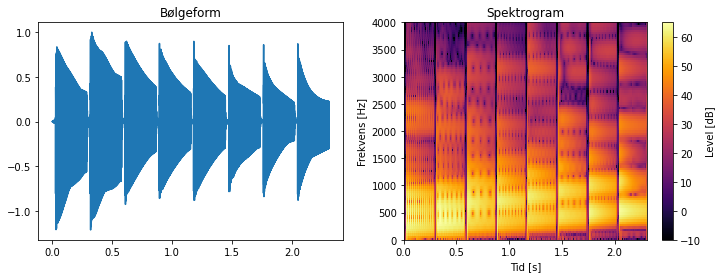

In [130]:
#@title Visualisering {run: "auto"}

spektrogram_fmax = "4000" #@param [1000,2000,4000,8000,16000]
spektrogram_fmax = int(spektrogram_fmax)
filename  = audioDir+audio_picker.value
#x,fs = utils.getAudio(filename)
x, fs = soundfile.read(filename)
if x.ndim == 1:
  x = x.reshape(-1,1)
x = x.T
x = processing.normalize().transform(x)

t = np.arange(len(x.T))/fs

stft = spectrum.STFT(fs=fs,nperseg=256,nfft=4,noverlapratio=0.9)
X = stft.transform(x)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(t,x[0].T/x[0].max())
plt.title("Bølgeform")

plt.subplot(122)
plt.pcolormesh(stft.t,stft.f,20*np.log10(np.abs(X[0])),vmin=-10,vmax=65,cmap='inferno')
plt.ylim([0,spektrogram_fmax])
plt.title("Spektrogram")
plt.ylabel("Frekvens [Hz]")
plt.xlabel("Tid [s]")
cbar = plt.colorbar()
cbar.set_label("Level [dB]")
plt.show()

display(utils.play(x,fs))

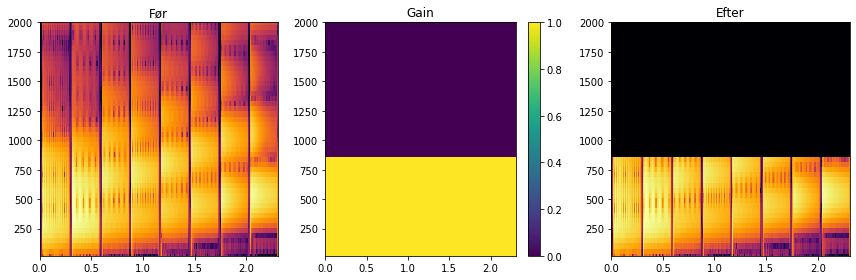

In [131]:
#@title Højpas og lavpas: {run: "auto"}

filename  = audioDir+audio_picker.value
x, fs = soundfile.read(filename)
if x.ndim == 1:
  x = x.reshape(-1,1)
x = x.T
x = processing.normalize().transform(x)

stft = spectrum.STFT(fs=fs,nperseg=256,nfft=4,noverlapratio=0.9)
X = stft.transform(x)


ftype = 'lowpass' #@param ['lowpass','highpass']
fcutoff = 824 #@param {type:"slider", min:0, max:1500, step:1}

mask = np.ones_like(X)
f_idx = np.argmin(stft.f < int(fcutoff))

if ftype == 'highpass':
  mask[:,0:f_idx,:] = 0
elif ftype == 'lowpass':
  mask[:,f_idx::,:] = 0

Y = mask * X

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.pcolormesh(stft.t,stft.f,20*np.log10(np.abs(X[0])),vmin=0,vmax=65,cmap='inferno')
plt.ylim([20,2000])
plt.title("Før")

plt.subplot(132)
plt.pcolormesh(stft.t,stft.f,np.real(mask[0]))
plt.ylim([20,2000])
plt.colorbar()
plt.title("Gain")


plt.subplot(133)
plt.pcolormesh(stft.t,stft.f,20*np.log10(np.abs(Y[0]+1e-99)),vmin=0,vmax=65,cmap='inferno')
plt.ylim([20,2000])
plt.title("Efter")

plt.tight_layout()
plt.show()

Enable_audio = True #@param {type:"boolean"}
if Enable_audio:
  y = stft.transform(Y,inv=True)
  display(utils.play(y,fs))

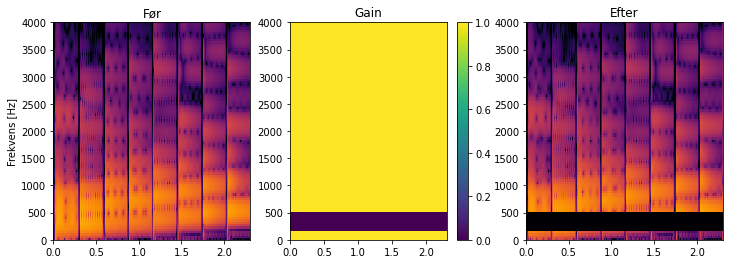

In [134]:
#@title Båndstop filter {run: "auto"}

filename  = audioDir+audio_picker.value
x, fs = soundfile.read(filename)
if x.ndim == 1:
  x = x.reshape(-1,1)
x = x.T
x = processing.normalize().transform(x)

stft = spectrum.STFT(fs=fs,nperseg=256,nfft=4,noverlapratio=0.9)
X = stft.transform(x)


fCenter = 320 #@param {type:"slider",min:100, max:2000,step:10}
fWidth = 4 #@param {type:"slider",min:1,max:50,step:1}

fCenterIdx = np.argmin(stft.f < fCenter)

mask = np.ones_like(X)

mask[:,fCenterIdx-fWidth:fCenterIdx+fWidth,:] *= 0

Y = mask * X

plt.figure(figsize=(12,4))

plt.subplot(131)

plt.pcolormesh(stft.t,stft.f,20*np.log10(np.abs(X[0]+1e-99)),vmin=0,vmax=80,cmap='inferno')
plt.ylim([0,4000])
plt.title("Før")
plt.ylabel("Frekvens [Hz]")

plt.subplot(132)

plt.pcolormesh(stft.t,stft.f,(np.abs(mask[0]+1e-99)))
plt.colorbar()
plt.ylim([0,4000])
plt.title("Gain")

plt.subplot(133)
plt.pcolormesh(stft.t,stft.f,20*np.log10(np.abs(Y[0]+1e-99)),vmin=0,vmax=80,cmap='inferno')
plt.ylim([0,4000])
plt.title("Efter")


y = stft.transform(Y,inv=True)

display(utils.play(y,fs))


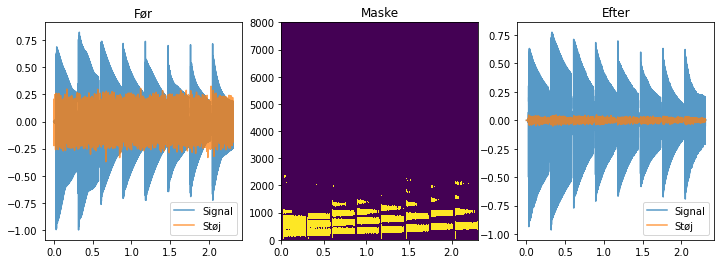

RMS Signal før: [0.23736382 0.23736373] 
RMS Støj før: [0.07506103 0.075061  ] 
SNRdB før: [10. 10.] 
RMS Signal efter: [0.23342091 0.23338427]
RMS Støj efter: [0.01147424 0.01145696]


In [136]:
#@title støjreduktion {run: "auto"}

filename  = audioDir+audio_picker.value
x, fs = soundfile.read(filename)
if x.ndim == 1:
  x = x.reshape(-1,1)
x = x.T
x = x/np.max(np.abs(x))

SNRdB = 10 #@param {type:"slider",min:-24,max:24}
xn = interferringNoise(x,fs,SNR=SNRdB)

xm = x + xn
t = np.arange(len(x.T))/fs

stft = spectrum.STFT(nperseg=512,fs=fs)

# Compute STFTs
X = stft.transform(x)
Xn = stft.transform(xn)
Xm = stft.transform(xm)

# Thresholding in log spectrogram, that way the linear slider makes more sense
XmLog = np.log(np.abs(Xm))
minVal = np.min(XmLog)
maxVal = np.max(XmLog)

threshold_percent = 81 #@param {type:"slider", min:0, max:100, step:1}
a = threshold_percent/100

thr = a * maxVal + (1-a) * minVal
mask = XmLog > thr

Y = mask * X
Yn = mask * Xn
Ym = mask * Xm

y = stft.transform(Y,inv=True)
yn = stft.transform(Yn,inv=True)
ym = stft.transform(Ym)

#plt.pcolormesh(stft.t,stft.f,mask[0])

plt.figure(figsize=(12,4))

plt.subplot(131)
t = np.arange(len(x[0].T))/fs
plt.plot(t,x[0].T,label='Signal',alpha=0.75)
plt.plot(t,xn[0].T,label='Støj',alpha=0.75)
plt.title("Før")
plt.legend()

plt.subplot(132)
plt.pcolormesh(stft.t,stft.f,mask[0])
plt.ylim([0,8000])
plt.title("Maske")


plt.subplot(133)
t = np.arange(len(y[0].T))/fs
plt.plot(t,y[0].T,label='Signal',alpha=0.75)
plt.plot(t,yn[0].T,label='Støj',alpha=0.75)
plt.title("Efter")
plt.legend()
plt.show()

display(utils.play(ym,fs))

print(f"RMS Signal før: {utils.rms(x)} ")
print(f"RMS Støj før: {utils.rms(xn)} ")
print(f"SNRdB før: {20*np.log10(utils.rms(x)/utils.rms(xn))} ")

print(f"RMS Signal efter: {utils.rms(y)}")
print(f"RMS Støj efter: {utils.rms(yn)}")
 